# Scalability Analysis: ETL & Data Processing

### Zielsetzung
Dieses Notebook untersucht die **Skalierbarkeit** (Scalability) von Data-Engineering-Pipelines. Wir simulieren wachsende Datenlasten ("Load"), um das Systemverhalten empirisch zu messen.

### Hypothese
Wir erwarten für typische ETL-Operationen (Aggregationen) eine **lineare Zeitkomplexität**. Das bedeutet: Doppelte Datenmenge führt zu doppelter Rechenzeit, während der Durchsatz (Rows/sec) stabil bleiben sollte.

In [23]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Design-Settings
sns.set_theme(style="whitegrid")

print("--- 1. SETUP: DATEN LADEN ---")
# Wir laden den aktuellsten Spark-Run
base_path = "../data/processed/run_*"
if not glob.glob(base_path): base_path = "../../data/processed/run_*"
latest_run = max(glob.glob(base_path), key=os.path.getctime)

print(f"Lade Datensatz: {os.path.basename(latest_run)}")
df_full = pd.read_parquet(latest_run)

# Cleaning & Typisierung
cols = ['velocity', 'baroaltitude']
for c in cols: df_full[c] = pd.to_numeric(df_full[c], errors='coerce')
df_clean = df_full[df_full['onground'] == 'False'].dropna(subset=cols).copy()
df_clean['velocity_kmh'] = df_clean['velocity'] * 3.6

print(f"Bereit: {len(df_clean):,} Zeilen im RAM.")

--- 1. SETUP: DATEN LADEN ---
Lade Datensatz: run_1769345704
Bereit: 1,080,730 Zeilen im RAM.


### Experiment 1: Throughput

Wir untersuchen die **Durchsatzrate** (Efficiency) einer typischen ETL-Aufgabe (Aggregation: `Group By` + `Mean/Max/Min`).

* **Variable:** Datengröße von **20%** bis **500%**.
* **Metrik:** Durchsatz (Verarbeitete Zeilen pro Sekunde).
* **Methode:**
    * Bei kleinen Datenmengen (< 1 Mio. Zeilen) wiederholen wir die Messung **50x**, um Rauschen zu eliminieren.
    * Bei großen Datenmengen (> 5 Mio. Zeilen) reduzieren wir auf **10x**, da die Laufzeit lang genug für präzise Messungen ist.
* **Erwartung:** Wir wollen sehen, wie der Durchsatz ansteigt (Overhead-Amortisierung) und sich dann auf einem stabilen Niveau einpendelt (Hardware-Sättigung).

--- 2. Troughput-Rate ---
🚀 Starte Test (0.2x bis 5.0x)...
   Faktor: 0.2x |    216,146 Zeilen | Zeit (ges.):  2.06s | Speed: 5,254,603 Rows/s
   Faktor: 0.4x |    432,292 Zeilen | Zeit (ges.):  2.86s | Speed: 7,548,369 Rows/s
   Faktor: 0.6x |    648,438 Zeilen | Zeit (ges.):  3.93s | Speed: 8,251,572 Rows/s
   Faktor: 0.8x |    864,584 Zeilen | Zeit (ges.):  5.13s | Speed: 8,424,285 Rows/s
   Faktor: 1.0x |  1,080,730 Zeilen | Zeit (ges.):  6.27s | Speed: 8,625,106 Rows/s
   Faktor: 2.0x |  2,161,460 Zeilen | Zeit (ges.):  2.32s | Speed: 9,309,401 Rows/s
   Faktor: 3.0x |  3,242,190 Zeilen | Zeit (ges.):  3.34s | Speed: 9,694,549 Rows/s
   Faktor: 4.0x |  4,322,920 Zeilen | Zeit (ges.):  4.38s | Speed: 9,871,630 Rows/s
   Faktor: 5.0x |  5,403,650 Zeilen | Zeit (ges.):  5.40s | Speed: 10,008,592 Rows/s
Messreihe abgeschlossen.


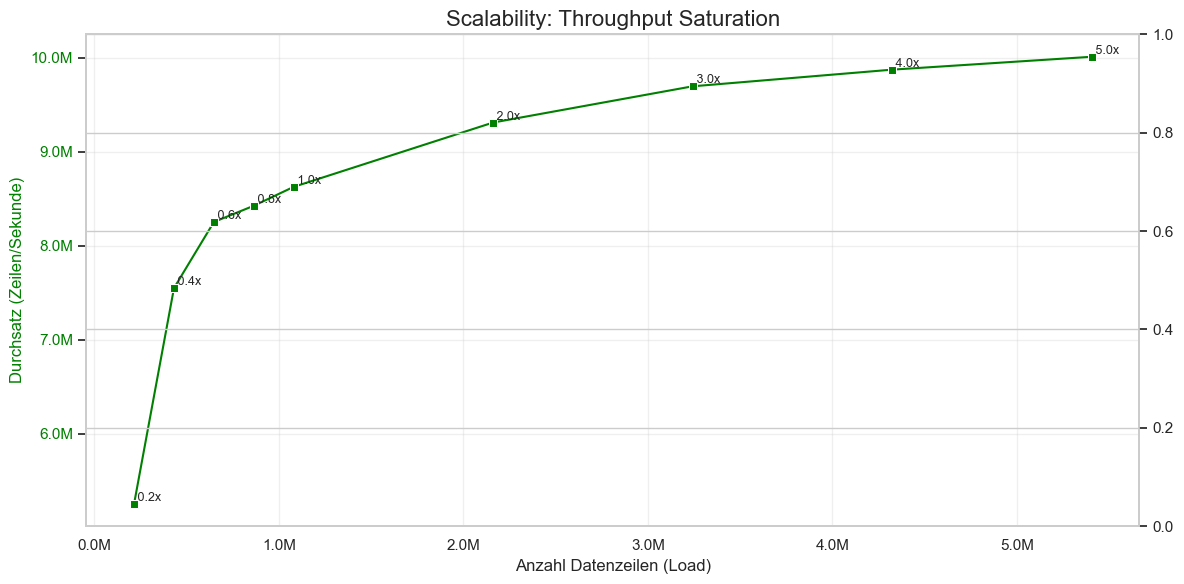

In [24]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

print("--- 2. Troughput-Rate ---")

factors = [0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0] 

results = []

print(f"🚀 Starte Test ({min(factors)}x bis {max(factors)}x)...")

for f in factors:
    # 1. Daten vorbereiten (Entweder samplen oder vervielfachen)
    if f <= 1.0:
        df_work = df_clean.sample(frac=f, random_state=42)
        current_repeats = 50 # Viel Wiederholung bei kleinen Daten
    else:
        # Int(f) weil wir ganze Kopien brauchen (z.B. 2x, 3x)
        df_work = pd.concat([df_clean] * int(f), ignore_index=True)
        current_repeats = 10 # Weniger Wiederholung bei Big Data (dauert sonst zu lang)
        
    n_rows = len(df_work)
    
    # 2. Messung
    start_time = time.time()
    
    # Der Workload
    for _ in range(current_repeats):
        df_work.groupby('icao24')[['velocity_kmh', 'baroaltitude']].agg(['mean', 'max', 'min'])
        
    end_time = time.time()
    
    # Aufräumen (RAM sparen bei den großen Brocken)
    if f > 1.0: 
        del df_work
    
    # 3. Metriken berechnen
    duration = end_time - start_time

    total_rows_processed = n_rows * current_repeats
    throughput = total_rows_processed / duration 
    
    print(f"   Faktor: {f:3.1f}x | {n_rows:10,} Zeilen | Zeit (ges.): {duration:5.2f}s | Speed: {int(throughput):,} Rows/s")
    
    results.append({
        'factor': f,
        'n_rows': n_rows,
        'duration_total': duration,
        'throughput': throughput
    })

print("Messreihe abgeschlossen.")
df_results = pd.DataFrame(results)

# --- VISUALISIERUNG ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# 1. LINIE: Durchsatz (Das, was uns interessiert) -> Grün
sns.lineplot(data=df_results, x='n_rows', y='throughput', marker='s', color='green', ax=ax1, label='Durchsatz (Effizienz)', legend=False)
ax1.set_xlabel('Anzahl Datenzeilen (Load)', fontsize=12)
ax1.set_ylabel('Durchsatz (Zeilen/Sekunde)', color='green', fontsize=12)
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True, alpha=0.3)

# Achsen formatieren (Millionen)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# 2. LINIE: Laufzeit (Blau) - als Referenz
ax2 = ax1.twinx()

plt.title('Scalability: Throughput Saturation', fontsize=16)

# Damit man sieht wo die Punkte sind
for x, y, f in zip(df_results['n_rows'], df_results['throughput'], df_results['factor']):
    ax1.text(x, y, f' {f}x', fontsize=9, verticalalignment='bottom')

plt.tight_layout()
plt.show()

### Experiment 2: Space Complexity & Stress Test

Nach der Zeit-Analyse prüfen wir nun den **Speicherbedarf** (Space Complexity).
* **Szenario:** Wir simulieren "Big Data", indem wir den Datensatz künstlich vervielfachen (Synthetic Upscaling bis zum 5-fachen Volumen).
* **Metrik:** Peak RAM Usage (Maximaler Arbeitsspeicher-Verbrauch in MB).
* **Ziel:** Wir wollen ausschließen, dass der Speicherbedarf exponentiell wächst, was das System bei großen Datenmengen zum Absturz bringen würde ("Out of Memory").

--- 3. RAM & CPU Skalierung bei steigender Datenmenge ---
Starte Stress-Test (Basis: 1,080,730 Zeilen)...
   Last: 10x | Zeit:  1.16s | RAM:  206.8 MB | CPU-Time:  1.14s
   Last: 20x | Zeit:  2.27s | RAM:  379.7 MB | CPU-Time:  2.14s
   Last: 30x | Zeit:  3.20s | RAM:  552.6 MB | CPU-Time:  3.14s
   Last: 40x | Zeit:  4.63s | RAM:  725.6 MB | CPU-Time:  4.47s
   Last: 50x | Zeit:  5.95s | RAM:  898.5 MB | CPU-Time:  5.62s


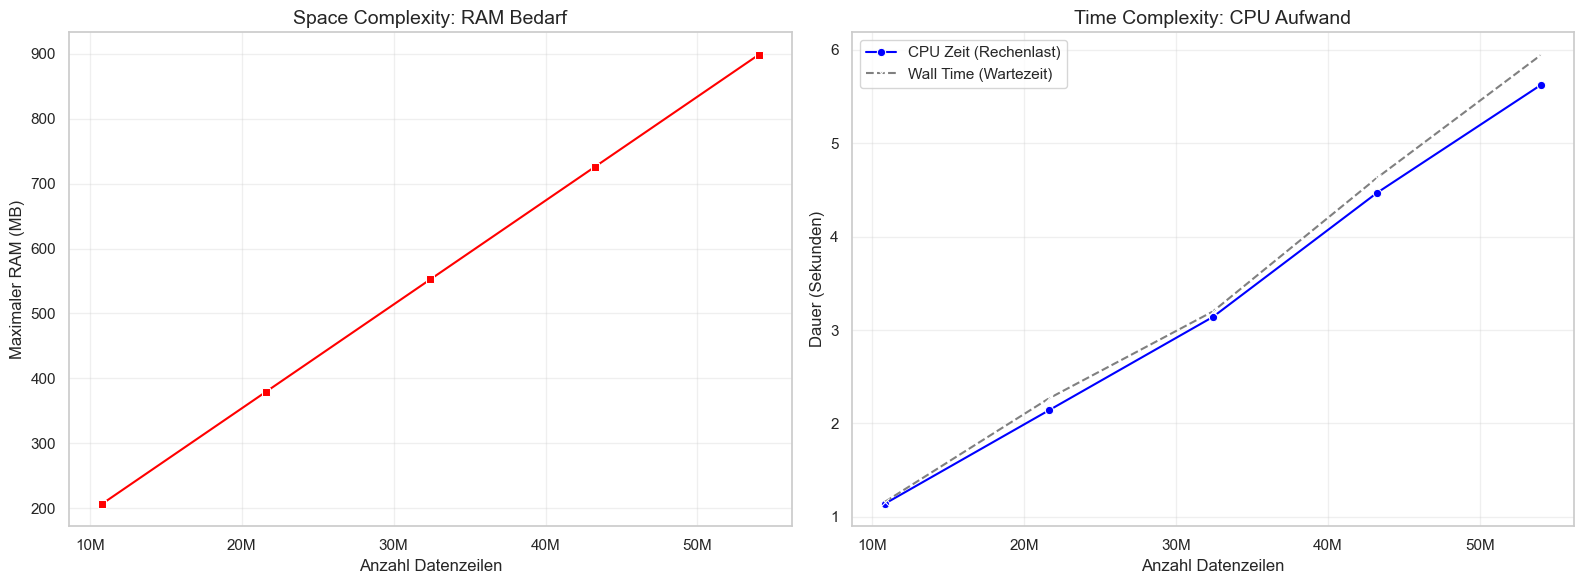

In [25]:
import tracemalloc
import seaborn as sns
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

print("--- 3. RAM & CPU Skalierung bei steigender Datenmenge ---")

# Konfiguration:
multipliers = [10, 20, 30, 40, 50] 
stress_results = []
original_len = len(df_clean)

print(f"Starte Stress-Test (Basis: {original_len:,} Zeilen)...")

for m in multipliers:
    # A) Daten synthetisch aufblähen
    df_big = pd.concat([df_clean] * m, ignore_index=True)
    n_rows = len(df_big)
    
    # B) Messung starten (RAM & Zeit)
    tracemalloc.start()
    
    start_wall = time.time()          # Echte Zeit (Wand-Uhr)
    start_cpu  = time.process_time()  # CPU-Zeit (Reine Rechenzeit)
    
    # Workload: Aggregation
    df_big.groupby('icao24')[['velocity_kmh', 'baroaltitude']].agg(['mean', 'max', 'min'])
    
    # Messung stoppen
    end_wall = time.time()
    end_cpu  = time.process_time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # Berechnungen
    duration_wall = end_wall - start_wall
    duration_cpu  = end_cpu - start_cpu
    peak_mb = peak / 10**6
    
    # CPU-Ratio (Parallelisierungsgrad)
    cpu_ratio = duration_cpu / duration_wall if duration_wall > 0 else 0
    
    print(f"   Last: {m:2}x | Zeit: {duration_wall:5.2f}s | RAM: {peak_mb:6.1f} MB | CPU-Time: {duration_cpu:5.2f}s")
    
    stress_results.append({
        'n_rows': n_rows,
        'duration_wall': duration_wall, # Wie lange du wartest
        'duration_cpu': duration_cpu,   # Wie viel die CPU arbeitet
        'peak_ram_mb': peak_mb,
        'cpu_ratio': cpu_ratio
    })
    
    del df_big

# --- VISUALISIERUNG (2 getrennte Graphen) ---
df_stress = pd.DataFrame(stress_results)

# Wir erstellen 2 Diagramme nebeneinander (1 Zeile, 2 Spalten)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# GRAPH 1: RAM-Bedarf (Space Complexity)
# Ziel: Ist die Linie gerade? -> Linearer Speicherverbrauch
sns.lineplot(data=df_stress, x='n_rows', y='peak_ram_mb', marker='s', color='red', ax=ax1)
ax1.set_title('Space Complexity: RAM Bedarf', fontsize=14)
ax1.set_xlabel('Anzahl Datenzeilen', fontsize=12)
ax1.set_ylabel('Maximaler RAM (MB)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.0f}M'))

# GRAPH 2: CPU-Aufwand (Time Complexity)
# Ziel: Ist die Linie gerade? -> Linearer Rechenaufwand
# Wir plotten die CPU-Zeit (blau) und vergleichen sie mit der Wartezeit (gestrichelt)
sns.lineplot(data=df_stress, x='n_rows', y='duration_cpu', marker='o', color='blue', label='CPU Zeit (Rechenlast)', ax=ax2)
sns.lineplot(data=df_stress, x='n_rows', y='duration_wall', marker='x', color='gray', linestyle='--', label='Wall Time (Wartezeit)', ax=ax2)

ax2.set_title('Time Complexity: CPU Aufwand', fontsize=14)
ax2.set_xlabel('Anzahl Datenzeilen', fontsize=12)
ax2.set_ylabel('Dauer (Sekunden)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.0f}M'))
ax2.legend()

plt.tight_layout()
plt.show()